In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [65]:
def grad_U(Ui, Yij, Vj, Ai, Bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - (np.dot(Ui, Vj) + Ai + Bj)))

def grad_V(Ui, Yij, Vj, Ai, Bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - (np.dot(Ui, Vj) + Ai + Bj)))

def grad_A(Ui, Yij, Vj, Ai, Bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ai multiplied by eta.
    """
    return eta * (reg * Ai - (Yij - (np.dot(Ui, Vj) + Ai + Bj)))
    
def grad_B(Ui, Yij, Vj, Ai, Bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Bj multiplied by eta.
    """
    return eta * (reg * Bj - (Yij - (np.dot(Ui, Vj) + Ai + Bj)))

def get_err(U, V, A, B, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
        
    reg_term = reg / 2 * (np.linalg.norm(U, ord='fro') +
                          np.linalg.norm(V, ord='fro') +
                          np.linalg.norm(A) +
                          np.linalg.norm(B) )
    
    cum_sum = 0
    
    for Yij in Y:
        cum_sum += np.square(np.dot(U[int(Yij[0])-1], V[int(Yij[1])-1]) + A[int(Yij[0])-1] + B[int(Yij[1])-1] - Yij[2])
    
    return cum_sum / (2 * len(Y)) + reg_term


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U and V to small random numbers
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    A = np.random.rand(M) - 0.5
    B = np.random.rand(N) - 0.5
    
    # Calculate initial error
    errors = [get_err(U, V, A, B, Y, reg=reg)]
    
    test_errors = [get_err(U, V, A, B, Y)]
    
    # Implement SGD
    for epoch in range(max_epochs):
        curr_ord = np.random.permutation(Y)
        
        # Loop through each data point in the epoch
        for point in curr_ord:
            i = int(point[0])
            j = int(point[1])
            Yij = point[2]
            i -= 1
            j -= 1
            du = grad_U(U[i], Yij, V[j], A[i], B[j], reg, eta)
            dv = grad_V(U[i], Yij, V[j], A[i], B[j], reg, eta)
            da = grad_A(U[i], Yij, V[j], A[i], B[j], reg, eta)
            db = grad_B(U[i], Yij, V[j], A[i], B[j], reg, eta)
            U[i] -= du
            V[j] -= dv
            A[i] -= da
            B[j] -= db
            
        # Compare errors and exit if we've converged
        errors.append(get_err(U, V, A, B, Y, reg=reg))
        test_errors.append(get_err(U, V, A, B, Y))
        if errors[-2] - errors[-1] < eps * (errors[0] - errors[1]) or errors[-2] - errors[-1] < 0:
            break
            
    return (U, V, A, B, get_err(U, V, A, B, Y))

In [53]:
# Load and manipulate train/test data
train = np.loadtxt('./data/train.txt', delimiter='\t')
test = np.loadtxt('./data/test.txt', delimiter='\t')

In [54]:
train[:, 2] -= np.mean(train, axis=0)[2]
test[:, 2] -= np.mean(test, axis=0)[2]

In [66]:
# Search through best possible parameters
M = 943
N = 1682
k = 20

E_in = []
E_out = []

regs = [1e-3, 1e-2, 1e-1, 1]
etas = [5e-4, 5e-3, 1e-2, 3e-2]

for reg in regs:
    E_in1 = []
    E_out1 = []
    for eta in etas:
        U, V, A, B, train_err = train_model(M, N, k, eta, reg, train)
        test_err = get_err(U, V, A, B, test)
        E_in1.append(train_err)
        E_out1.append(test_err)
    E_in.append(E_in1)
    E_out.append(E_out1)

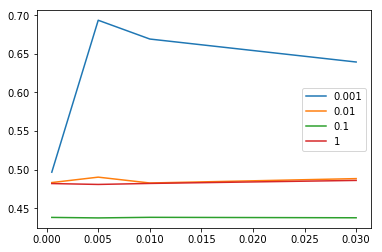

In [73]:
plt.figure()

for ind, reg in enumerate(regs):
    plt.plot(etas, E_out[ind], label=str(reg))
plt.legend()

In [ ]:
# Load data and packages for visualization
